In [4]:
import pandas as pd
import numpy as np

# 파일 불러오기
data = pd.read_csv('C:\\Users\\tpgo2\\OneDrive - 성균관대학교\\바탕 화면\\fhir\\final2.csv') 
range2 = pd.read_csv('C:\\Users\\tpgo2\\OneDrive - 성균관대학교\\바탕 화면\\fhir\\elderly_test_normal_ranges.csv',encoding='cp949') 

In [6]:
data['Careplan'].unique()

array(['Dementia management', 'Musculoskeletal care', 'Cancer care plan',
       'Fracture care', 'Inpatient care plan (record artifact)',
       'Lifestyle education regarding hypertension',
       'Diabetes self management plan'], dtype=object)

In [5]:
# Create a dictionary to map tests to their normal ranges
range_dict_updated = range2.set_index('Test').to_dict(orient='index')

# Function to classify the value based on normal range with the updated logic
def classify_value_updated(observation, value):
    if observation in range_dict_updated:
        min_val = range_dict_updated[observation]['min']
        max_val = range_dict_updated[observation]['max']
        if pd.notna(min_val) and pd.isna(max_val):
            return 1 if value >= min_val else 0
        elif pd.isna(min_val) and pd.notna(max_val):
            return 1 if value <= max_val else 2
        elif pd.notna(min_val) and pd.notna(max_val):
            if value < min_val:
                return 0
            elif value > max_val:
                return 2
            else:
                return 1
        else:
            return np.nan  # If both min and max are NaN
    else:
        return np.nan  # If the test is not found in the normal ranges

# Apply the updated classification function to the DataFrame
data['range'] = data.apply(lambda row: classify_value_updated(row['observation'], row['value']), axis=1)

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import onnx
import skl2onnx
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

# 데이터 로드 (예시)
# data = pd.read_csv('/path/to/your/data.csv')

# x_data와 y_data를 정의
x_data = data[['condition', 'observation', 'value', 'gender']]
y_data = data['Careplan']

# 레이블 인코딩
label_encoders = {}
for column in ['condition', 'observation', 'gender']:
    le = LabelEncoder()
    x_data[column] = le.fit_transform(x_data[column])
    label_encoders[column] = le

# target 변수 인코딩
y_encoder = LabelEncoder()
y_data = y_encoder.fit_transform(y_data)

# 데이터를 학습용과 테스트용으로 분리
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# 학습 세트에 SMOTE 적용
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

# 숫자형 변수 표준화
scaler = StandardScaler()
x_train_resampled[['value']] = scaler.fit_transform(x_train_resampled[['value']])
x_test[['value']] = scaler.transform(x_test[['value']])

C:\Users\tpgo2\AppData\Local\Temp\ipykernel_20092\2373537259.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_data[column] = le.fit_transform(x_data[column])
C:\Users\tpgo2\AppData\Local\Temp\ipykernel_20092\2373537259.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_data[column] = le.fit_transform(x_data[column])
C:\Users\tpgo2\AppData\Local\Temp\ipykernel_20092\2373537259.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

ValueError: The target 'y' needs to have more than 1 class. Got 1 class instead

In [ ]:
x_train_resampled

C:\Users\tpgo2\AppData\Local\Temp\ipykernel_19304\3572609265.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_data[column] = le.fit_transform(x_data[column])
C:\Users\tpgo2\AppData\Local\Temp\ipykernel_19304\3572609265.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_data[column] = le.fit_transform(x_data[column])
C:\Users\tpgo2\AppData\Local\Temp\ipykernel_19304\3572609265.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

Cross-Validation Accuracy Scores: [0.96625104 0.96707295 0.9670156  0.96505938 0.96680514]
Average Cross-Validation Accuracy: 0.9664408222391658
Accuracy: 0.9894197706013899
Classification Report:
                                             precision    recall  f1-score   support

                          Cancer care plan       1.00      1.00      1.00      8382
                       Dementia management       0.99      1.00      0.99     28175
             Diabetes self management plan       0.93      0.82      0.87       590
                             Fracture care       1.00      1.00      1.00        96
     Inpatient care plan (record artifact)       1.00      1.00      1.00      3098
Lifestyle education regarding hypertension       1.00      0.74      0.85      1143
                      Musculoskeletal care       1.00      1.00      1.00       103

                                  accuracy                           0.99     41587
                                 macro avg  

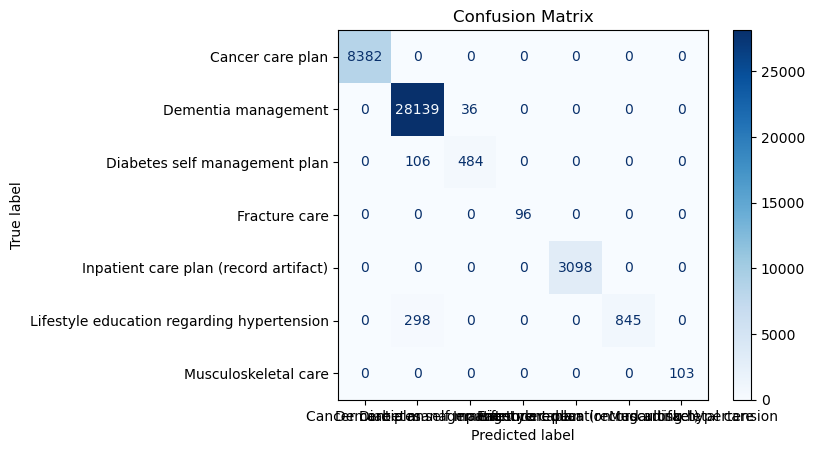

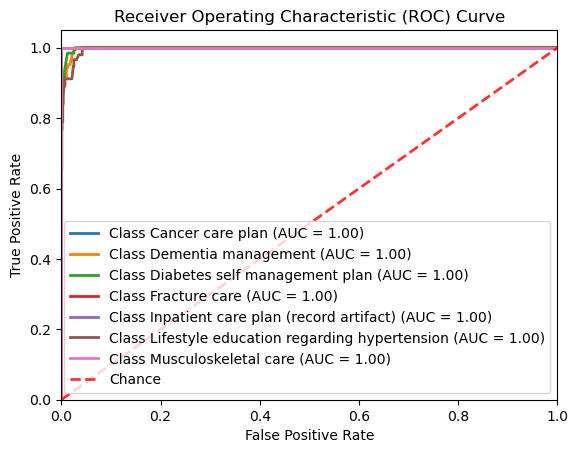

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import onnx
import skl2onnx
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

# 데이터 로드 (예시)
# data = pd.read_csv('/path/to/your/data.csv')

# x_data와 y_data를 정의
x_data = data[['condition', 'observation', 'value', 'gender']]
y_data = data['Careplan']

# 레이블 인코딩
label_encoders = {}
for column in ['condition', 'observation', 'gender']:
    le = LabelEncoder()
    x_data[column] = le.fit_transform(x_data[column])
    label_encoders[column] = le

# target 변수 인코딩
y_encoder = LabelEncoder()
y_data = y_encoder.fit_transform(y_data)

# 데이터를 학습용과 테스트용으로 분리
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# 학습 세트에 SMOTE 적용
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

# 숫자형 변수 표준화
scaler = StandardScaler()
x_train_resampled[['value']] = scaler.fit_transform(x_train_resampled[['value']])
x_test[['value']] = scaler.transform(x_test[['value']])

# 랜덤 포레스트 모델 단순화
clf = RandomForestClassifier(
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=50,
    random_state=42
)

# 교차 검증을 통한 모델 성능 검증
cv_scores = cross_val_score(clf, x_train_resampled, y_train_resampled, cv=5)
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Average Cross-Validation Accuracy: {np.mean(cv_scores)}')

# 모델 학습
clf.fit(x_train_resampled, y_train_resampled)

# 예측 확률 계산
y_pred_prob = clf.predict_proba(x_test)

# 각 클래스에 대한 최적의 임계값 찾기
optimal_thresholds = []
for i in range(y_pred_prob.shape[1]):
    fpr, tpr, thresholds = roc_curve(y_test == i, y_pred_prob[:, i])
    optimal_idx = (tpr - fpr).argmax()
    optimal_threshold = thresholds[optimal_idx]
    optimal_thresholds.append(optimal_threshold)

# 최적의 임계값을 적용하여 최종 예측 수행
y_pred_final = np.zeros_like(y_pred_prob)
for i in range(y_pred_prob.shape[1]):
    y_pred_final[:, i] = (y_pred_prob[:, i] >= optimal_thresholds[i]).astype(int)

y_pred_final = y_pred_final.argmax(axis=1)

# 예측 결과를 원래 클래스 값으로 변환
y_pred_final_labels = y_encoder.inverse_transform(y_pred_final)
y_test_labels = y_encoder.inverse_transform(y_test)

# 모델 평가
print("Accuracy:", accuracy_score(y_test_labels, y_pred_final_labels))
print("Classification Report:\n", classification_report(y_test_labels, y_pred_final_labels, target_names=y_encoder.classes_))

# 혼동 행렬 그리기
cm = confusion_matrix(y_test_labels, y_pred_final_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# ROC 곡선 및 AUC 계산 및 그래프 그리기
plt.figure()
for i in range(y_pred_prob.shape[1]):
    fpr, tpr, _ = roc_curve(y_test == i, y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {y_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# ONNX 파일로 저장
initial_type = [('float_input', FloatTensorType([None, x_train_resampled.shape[1]]))]
onnx_model = convert_sklearn(clf, initial_types=initial_type)

with open("random_forest_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [4]:
optimal_thresholds

[0.8998100118101364,
 0.18637397007086506,
 0.7389310938631555,
 1.0,
 0.9670366221456268,
 0.6114654535630563,
 1.0]

In [5]:
y_pred_final

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [6]:
y_test_labels

array(['Dementia management', 'Cancer care plan', 'Dementia management',
       ..., 'Dementia management', 'Dementia management',
       'Dementia management'], dtype=object)

In [1]:
data[data['Careplan']=='Diabetes self management plan']

NameError: name 'data' is not defined

In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import onnx
import skl2onnx
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType


# 데이터 로드 (예시)
# data = pd.read_csv('/path/to/your/data.csv')

# x_data와 y_data를 정의
x_data = data[['condition', 'observation', 'value', 'gender']]
y_data = data['Careplan']

# range가 NaN인 값을 레이블 인코딩된 카테고리 변수의 중앙값으로 대체
# 레이블 인코딩
label_encoders = {}
for column in ['condition', 'observation', 'gender']:
    le = LabelEncoder()
    x_data[column] = le.fit_transform(x_data[column])
    label_encoders[column] = le

# target 변수 인코딩
y_encoder = LabelEncoder()
y_data = y_encoder.fit_transform(y_data)

# 데이터를 학습용과 테스트용으로 분리
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# 학습 세트에 SMOTE 적용
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

# 숫자형 변수 표준화
scaler = StandardScaler()
x_train_resampled[['value']] = scaler.fit_transform(x_train_resampled[['value']])
x_test[['value']] = scaler.transform(x_test[['value']])

C:\Users\tpgo2\AppData\Local\Temp\ipykernel_31784\4163357000.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_data[column] = le.fit_transform(x_data[column])
C:\Users\tpgo2\AppData\Local\Temp\ipykernel_31784\4163357000.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_data[column] = le.fit_transform(x_data[column])
C:\Users\tpgo2\AppData\Local\Temp\ipykernel_31784\4163357000.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [11]:
y_train.unique

AttributeError: 'numpy.ndarray' object has no attribute 'unique'

In [9]:
y_test

array([1, 0, 1, ..., 1, 1, 1])

C:\Users\tpgo2\AppData\Local\Temp\ipykernel_29092\536236788.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_data[column] = le.fit_transform(x_data[column])
C:\Users\tpgo2\AppData\Local\Temp\ipykernel_29092\536236788.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_data[column] = le.fit_transform(x_data[column])
C:\Users\tpgo2\AppData\Local\Temp\ipykernel_29092\536236788.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Cross-Validation Accuracy Scores: [0.96625104 0.96707295 0.9670156  0.96505938 0.96680514]
Average Cross-Validation Accuracy: 0.9664408222391658
Accuracy: 0.9894197706013899
Classification Report:
                                             precision    recall  f1-score   support

                          Cancer care plan       1.00      1.00      1.00      8382
                       Dementia management       0.99      1.00      0.99     28175
             Diabetes self management plan       0.93      0.82      0.87       590
                             Fracture care       1.00      1.00      1.00        96
     Inpatient care plan (record artifact)       1.00      1.00      1.00      3098
Lifestyle education regarding hypertension       1.00      0.74      0.85      1143
                      Musculoskeletal care       1.00      1.00      1.00       103

                                  accuracy                           0.99     41587
                                 macro avg  

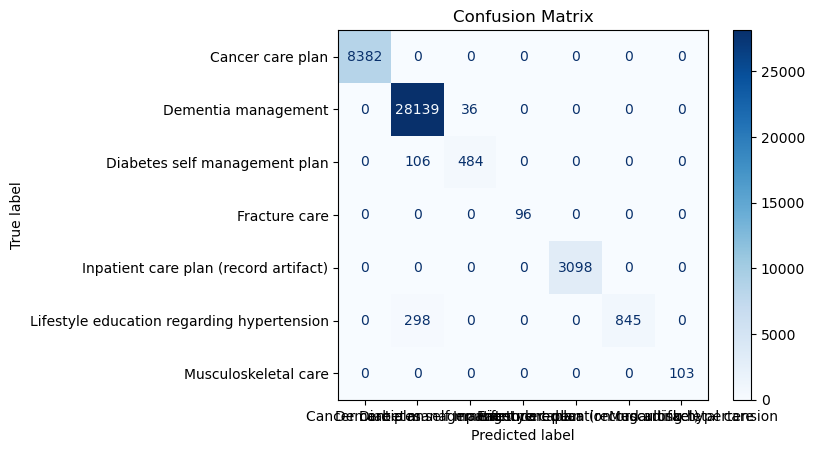

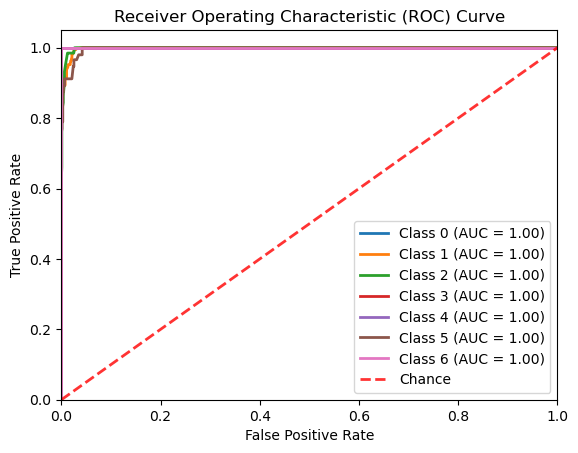

In [9]:
import onnx
import skl2onnx
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

# 데이터 로드 (예시)
# data = pd.read_csv('/path/to/your/data.csv')

# x_data와 y_data를 정의
x_data = data[['condition', 'observation', 'value', 'gender']]
y_data = data['Careplan']

# range가 NaN인 값을 레이블 인코딩된 카테고리 변수의 중앙값으로 대체
# 레이블 인코딩
label_encoders = {}
for column in ['condition', 'observation', 'gender']:
    le = LabelEncoder()
    x_data[column] = le.fit_transform(x_data[column])
    label_encoders[column] = le

# target 변수 인코딩
y_encoder = LabelEncoder()
y_data = y_encoder.fit_transform(y_data)

# 데이터를 학습용과 테스트용으로 분리
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# 학습 세트에 SMOTE 적용
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

# 숫자형 변수 표준화
scaler = StandardScaler()
x_train_resampled[['value']] = scaler.fit_transform(x_train_resampled[['value']])
x_test[['value']] = scaler.transform(x_test[['value']])

# 랜덤 포레스트 모델 단순화
clf = RandomForestClassifier(
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=50,
    random_state=42
)

# 교차 검증을 통한 모델 성능 검증
cv_scores = cross_val_score(clf, x_train_resampled, y_train_resampled, cv=5)
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Average Cross-Validation Accuracy: {np.mean(cv_scores)}')

# 모델 학습
clf.fit(x_train_resampled, y_train_resampled)

# 예측 확률 계산
y_pred_prob = clf.predict_proba(x_test)

# 각 클래스에 대한 최적의 임계값 찾기
optimal_thresholds = []
for i in range(y_pred_prob.shape[1]):
    fpr, tpr, thresholds = roc_curve(y_test == i, y_pred_prob[:, i])
    optimal_idx = (tpr - fpr).argmax()
    optimal_threshold = thresholds[optimal_idx]
    optimal_thresholds.append(optimal_threshold)

# 최적의 임계값을 적용하여 최종 예측 수행
y_pred_final = np.zeros_like(y_pred_prob)
for i in range(y_pred_prob.shape[1]):
    y_pred_final[:, i] = (y_pred_prob[:, i] >= optimal_thresholds[i]).astype(int)

y_pred_final = y_pred_final.argmax(axis=1)

# 모델 평가
print("Accuracy:", accuracy_score(y_test, y_pred_final))
print("Classification Report:\n", classification_report(y_test, y_pred_final, target_names=y_encoder.classes_.astype(str)))

# 혼동 행렬 그리기
cm = confusion_matrix(y_test, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# ROC 곡선 및 AUC 계산 및 그래프 그리기
plt.figure()
for i in range(y_pred_prob.shape[1]):
    fpr, tpr, _ = roc_curve(y_test == i, y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# ONNX 파일로 저장
initial_type = [('float_input', FloatTensorType([None, x_train_resampled.shape[1]]))]
onnx_model = convert_sklearn(clf, initial_types=initial_type)

with open("random_forest_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [10]:
# 모델에 들어가는 input 값 5행 출력
print("Training data (first 5 rows) after resampling and scaling:")
print(x_train_resampled.head())

print("\nTest data (first 5 rows) after scaling:")
print(x_test.head())

Training data (first 5 rows) after resampling and scaling:
   condition  observation     value  gender
0          1           31 -0.056441       1
1          0            8 -0.186578       1
2          5           51 -0.508991       1
3          0           29 -0.545947       0
4          3           49 -0.410528       1

Test data (first 5 rows) after scaling:
        condition  observation     value  gender
66089           0           13  0.741069       1
8644            6           40 -0.197210       1
60672           0           54  0.916583       1
164086          5           20 -0.013641       1
206650          5           51 -0.510224       0


In [7]:
data['Careplan'].unique()

array(['Dementia management', 'Musculoskeletal care', 'Cancer care plan',
       'Fracture care', 'Inpatient care plan (record artifact)',
       'Lifestyle education regarding hypertension',
       'Diabetes self management plan'], dtype=object)

C:\Users\tpgo2\AppData\Local\Temp\ipykernel_25060\3721757587.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_data[column] = le.fit_transform(x_data[column])
C:\Users\tpgo2\AppData\Local\Temp\ipykernel_25060\3721757587.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_data[column] = le.fit_transform(x_data[column])
C:\Users\tpgo2\AppData\Local\Temp\ipykernel_25060\3721757587.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

Cross-Validation Accuracy Scores: [0.96625104 0.96707295 0.9670156  0.96505938 0.96680514]
Average Cross-Validation Accuracy: 0.9664408222391658
Accuracy: 0.9894197706013899
Classification Report:
                                             precision    recall  f1-score   support

                          Cancer care plan       1.00      1.00      1.00      8382
                       Dementia management       0.99      1.00      0.99     28175
             Diabetes self management plan       0.93      0.82      0.87       590
                             Fracture care       1.00      1.00      1.00        96
     Inpatient care plan (record artifact)       1.00      1.00      1.00      3098
Lifestyle education regarding hypertension       1.00      0.74      0.85      1143
                      Musculoskeletal care       1.00      1.00      1.00       103

                                  accuracy                           0.99     41587
                                 macro avg  

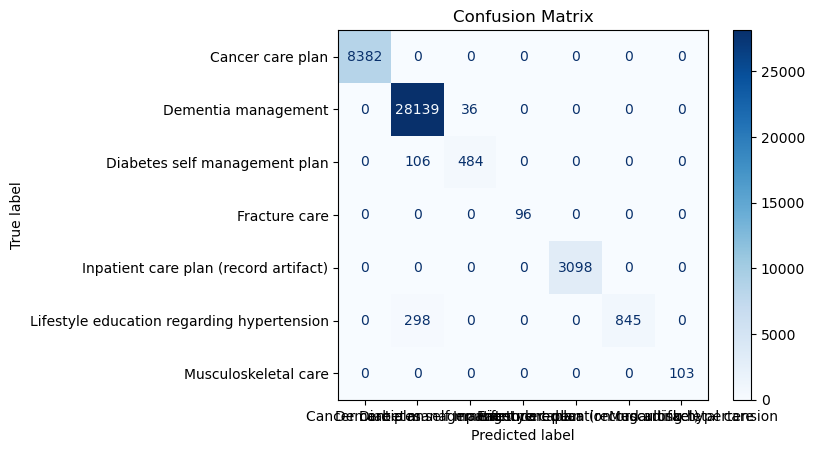

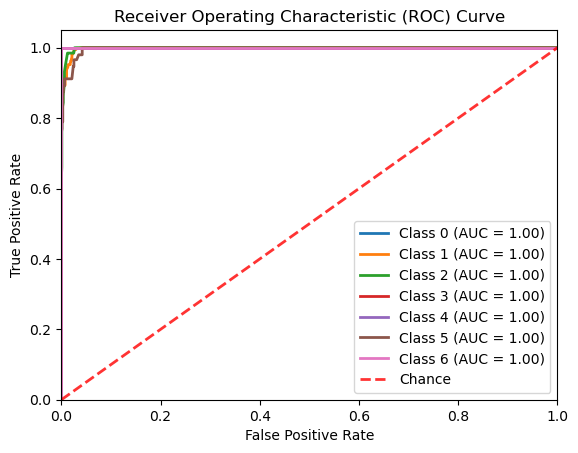

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt

# 데이터 로드 (예시)
# data = pd.read_csv('/path/to/your/data.csv')

# x_data와 y_data를 정의
x_data = data[['condition', 'observation', 'value', 'gender']]
y_data = data['Careplan']

# range가 NaN인 값을 레이블 인코딩된 카테고리 변수의 중앙값으로 대체
# 레이블 인코딩
label_encoders = {}
for column in ['condition', 'observation', 'gender']:
    le = LabelEncoder()
    x_data[column] = le.fit_transform(x_data[column])
    label_encoders[column] = le

# target 변수 인코딩
y_encoder = LabelEncoder()
y_data = y_encoder.fit_transform(y_data)

# 데이터를 학습용과 테스트용으로 분리
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# 학습 세트에 SMOTE 적용
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

# 숫자형 변수 표준화
scaler = StandardScaler()
x_train_resampled[['value']] = scaler.fit_transform(x_train_resampled[['value']])
x_test[['value']] = scaler.transform(x_test[['value']])

# 랜덤 포레스트 모델 단순화
clf = RandomForestClassifier(
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=50,
    random_state=42
)

# 교차 검증을 통한 모델 성능 검증
cv_scores = cross_val_score(clf, x_train_resampled, y_train_resampled, cv=5)
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Average Cross-Validation Accuracy: {np.mean(cv_scores)}')

# 모델 학습
clf.fit(x_train_resampled, y_train_resampled)

# 예측 확률 계산
y_pred_prob = clf.predict_proba(x_test)

# 각 클래스에 대한 최적의 임계값 찾기
optimal_thresholds = []
for i in range(y_pred_prob.shape[1]):
    fpr, tpr, thresholds = roc_curve(y_test == i, y_pred_prob[:, i])
    optimal_idx = (tpr - fpr).argmax()
    optimal_threshold = thresholds[optimal_idx]
    optimal_thresholds.append(optimal_threshold)

# 최적의 임계값을 적용하여 최종 예측 수행
y_pred_final = np.zeros_like(y_pred_prob)
for i in range(y_pred_prob.shape[1]):
    y_pred_final[:, i] = (y_pred_prob[:, i] >= optimal_thresholds[i]).astype(int)

y_pred_final = y_pred_final.argmax(axis=1)

# 모델 평가
print("Accuracy:", accuracy_score(y_test, y_pred_final))
print("Classification Report:\n", classification_report(y_test, y_pred_final, target_names=y_encoder.classes_.astype(str)))

# 혼동 행렬 그리기
cm = confusion_matrix(y_test, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# ROC 곡선 및 AUC 계산 및 그래프 그리기
plt.figure()
for i in range(y_pred_prob.shape[1]):
    fpr, tpr, _ = roc_curve(y_test == i, y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

C:\Users\tpgo2\AppData\Local\Temp\ipykernel_25060\3926747975.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_data[column] = le.fit_transform(x_data[column])
C:\Users\tpgo2\AppData\Local\Temp\ipykernel_25060\3926747975.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_data[column] = le.fit_transform(x_data[column])
C:\Users\tpgo2\AppData\Local\Temp\ipykernel_25060\3926747975.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

Cross-Validation Accuracy Scores: [0.99474365 0.99448242 0.99425943 0.99439319 0.99452062]
Average Cross-Validation Accuracy: 0.9944798620144987
Accuracy: 0.9735013345516628
Classification Report:
                                             precision    recall  f1-score   support

                          Cancer care plan       0.92      1.00      0.96      8382
                       Dementia management       1.00      0.96      0.98     28175
             Diabetes self management plan       1.00      1.00      1.00       590
                             Fracture care       1.00      1.00      1.00        96
     Inpatient care plan (record artifact)       1.00      1.00      1.00      3098
Lifestyle education regarding hypertension       0.74      1.00      0.85      1143
                      Musculoskeletal care       1.00      1.00      1.00       103

                                  accuracy                           0.97     41587
                                 macro avg  

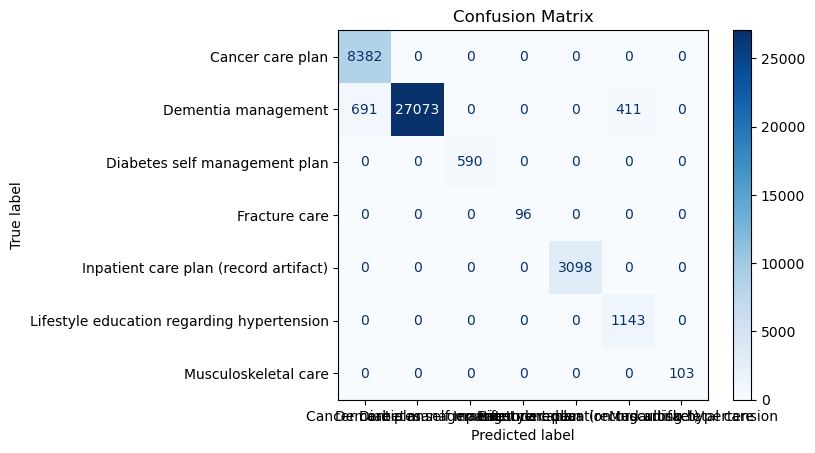

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt

# 데이터 로드 (예시)
# data = pd.read_csv('/path/to/your/data.csv')

# x_data와 y_data를 정의
x_data = data[['condition', 'observation', 'value', 'age', 'gender', 'range']]
y_data = data['Careplan']

# range가 NaN인 값을 레이블 인코딩된 카테고리 변수의 중앙값으로 대체
# 레이블 인코딩
label_encoders = {}
for column in ['condition', 'observation', 'gender']:
    le = LabelEncoder()
    x_data[column] = le.fit_transform(x_data[column])
    label_encoders[column] = le

# range가 NaN인 행을 식별
nan_range_rows = x_data[x_data['range'].isna()]

# 각 카테고리 변수의 중앙값을 계산하고 NaN을 대체
for column in ['condition', 'observation', 'gender']:
    median_value = x_data[column].median()
    x_data.loc[x_data['range'].isna(), column] = x_data.loc[x_data['range'].isna(), column].fillna(median_value)

# range 컬럼의 중앙값을 계산하고 NaN 값을 대체
range_median = x_data['range'].median()
x_data['range'].fillna(range_median, inplace=True)

# NaN 값이 없는지 확인
assert not x_data['range'].isna().any(), "There are still NaN values in the 'range' column."

# target 변수 인코딩
y_encoder = LabelEncoder()
y_data = y_encoder.fit_transform(y_data)

# 데이터를 학습용과 테스트용으로 분리
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# 학습 세트에 SMOTE 적용
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

# 숫자형 변수 표준화
scaler = StandardScaler()
x_train_resampled[['value', 'age']] = scaler.fit_transform(x_train_resampled[['value', 'age']])
x_test[['value', 'age']] = scaler.transform(x_test[['value', 'age']])

# 랜덤 포레스트 모델 단순화
clf = RandomForestClassifier(
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=50,
    random_state=42
)

# 교차 검증을 통한 모델 성능 검증
cv_scores = cross_val_score(clf, x_train_resampled, y_train_resampled, cv=5)
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Average Cross-Validation Accuracy: {np.mean(cv_scores)}')

# 모델 학습
clf.fit(x_train_resampled, y_train_resampled)

# 예측 확률 계산
y_pred_prob = clf.predict_proba(x_test)

# 각 클래스에 대한 최적의 임계값 찾기
optimal_thresholds = []
for i in range(y_pred_prob.shape[1]):
    fpr, tpr, thresholds = roc_curve(y_test == i, y_pred_prob[:, i])
    optimal_idx = (tpr - fpr).argmax()
    optimal_threshold = thresholds[optimal_idx]
    optimal_thresholds.append(optimal_threshold)

# 최적의 임계값을 적용하여 최종 예측 수행
y_pred_final = np.zeros_like(y_pred_prob)
for i in range(y_pred_prob.shape[1]):
    y_pred_final[:, i] = (y_pred_prob[:, i] >= optimal_thresholds[i]).astype(int)

y_pred_final = y_pred_final.argmax(axis=1)

# 모델 평가
print("Accuracy:", accuracy_score(y_test, y_pred_final))
print("Classification Report:\n", classification_report(y_test, y_pred_final, target_names=y_encoder.classes_.astype(str)))

# 혼동 행렬 그리기
cm = confusion_matrix(y_test, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207934 entries, 0 to 207933
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   period             207934 non-null  object 
 1   Careplan           207934 non-null  object 
 2   patient_id         207934 non-null  object 
 3   condition          207934 non-null  object 
 4   observation        207934 non-null  object 
 5   value              207934 non-null  float64
 6   unit               207934 non-null  object 
 7   display_x          199583 non-null  object 
 8   medication_statue  207934 non-null  object 
 9   display_y          207934 non-null  object 
 10  encounters_statue  207934 non-null  object 
 11  gender             207934 non-null  object 
 12  birthDate          207934 non-null  object 
 13  age                207934 non-null  int64  
 14  range              153042 non-null  float64
dtypes: float64(2), int64(1), object(12)
memory usage: 2

In [43]:
# Display rows where 'range' column has NaN values
nan_range_rows = data[data['range'].isna()]

# Display the rows
print(nan_range_rows[['observation','value']])

                                              observation   value
0                                      Total score [MMSE]  19.988
1                                      Total score [MMSE]  19.988
2                                      Total score [MMSE]  19.988
3                                      Total score [MMSE]  19.988
4                                      Total score [MMSE]  19.988
...                                                   ...     ...
207929  Glomerular filtration rate/1.73 sq M.predicted...  93.920
207930  Glomerular filtration rate/1.73 sq M.predicted...  93.920
207931  Glomerular filtration rate/1.73 sq M.predicted...  93.920
207932  Glomerular filtration rate/1.73 sq M.predicted...  93.920
207933  Glomerular filtration rate/1.73 sq M.predicted...  93.920

[54892 rows x 2 columns]


In [45]:
len(data)

207934

In [44]:
nan_range_rows['observation'].unique()

array(['Total score [MMSE]',
       'Pain severity - 0-10 verbal numeric rating [Score] - Reported',
       'Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum or Plasma by Creatinine-based formula (MDRD)',
       'Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma',
       'Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma',
       'Body Height', 'Body Weight', 'NT-proBNP',
       'Glucose [Mass/volume] in Serum or Plasma',
       'Urea nitrogen [Mass/volume] in Serum or Plasma',
       'Creatinine [Mass/volume] in Serum or Plasma',
       'Calcium [Mass/volume] in Serum or Plasma',
       'Sodium [Moles/volume] in Serum or Plasma',
       'Potassium [Moles/volume] in Serum or Plasma',
       'Chloride [Moles/volume] in Serum or Plasma',
       'Carbon dioxide, total [Moles/volume] in Serum or Plasma',
       'Iron binding capacity [Mass/volume] in Serum or Plasma'],
      dtype=object)

In [41]:
data[['range','value']]

,range,value
0,NaN,19.988
1,NaN,19.988
2,NaN,19.988
3,NaN,19.988
4,NaN,19.988
...,...,...
207929,NaN,93.920
207930,NaN,93.920
207931,NaN,93.920
207932,NaN,93.920


In [46]:
x_data=data[['condition','observation','value','age','gender','range']]
y_data=data[['Careplan']]

In [22]:
y_data.value_counts()

Careplan                                  
Dementia management                           140284
Cancer care plan                               42504
Inpatient care plan (record artifact)          15580
Lifestyle education regarding hypertension      5640
Diabetes self management plan                   2964
Musculoskeletal care                             482
Fracture care                                    480
dtype: int64

In [23]:
x_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207934 entries, 0 to 207933
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   condition    207934 non-null  object 
 1   observation  207934 non-null  object 
 2   value        207934 non-null  float64
 3   age          207934 non-null  int64  
 4   gender       207934 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 7.9+ MB


In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Encode categorical variables
label_encoders = {}
for column in ['condition', 'observation', 'gender']:
    le = LabelEncoder()
    x_data[column] = le.fit_transform(x_data[column])
    label_encoders[column] = le

# Encode target variable
y_encoder = LabelEncoder()
y_data = y_encoder.fit_transform(y_data)

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# Standardize the numerical variables
scaler = StandardScaler()
x_train[['value', 'age']] = scaler.fit_transform(x_train[['value', 'age']])
x_test[['value', 'age']] = scaler.transform(x_test[['value', 'age']])

# Train a RandomForest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(x_train, y_train)

# Make predictions
y_pred = clf.predict(x_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=y_encoder.classes_))

C:\Users\tpgo2\AppData\Local\Temp\ipykernel_2836\3511529933.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_data[column] = le.fit_transform(x_data[column])
C:\Users\tpgo2\AppData\Local\Temp\ipykernel_2836\3511529933.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_data[column] = le.fit_transform(x_data[column])
C:\Users\tpgo2\AppData\Local\Temp\ipykernel_2836\3511529933.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Accuracy: 1.0
Classification Report:
                                             precision    recall  f1-score   support

                          Cancer care plan       1.00      1.00      1.00      8382
                       Dementia management       1.00      1.00      1.00     28175
             Diabetes self management plan       1.00      1.00      1.00       590
                             Fracture care       1.00      1.00      1.00        96
     Inpatient care plan (record artifact)       1.00      1.00      1.00      3098
Lifestyle education regarding hypertension       1.00      1.00      1.00      1143
                      Musculoskeletal care       1.00      1.00      1.00       103

                                  accuracy                           1.00     41587
                                 macro avg       1.00      1.00      1.00     41587
                              weighted avg       1.00      1.00      1.00     41587



In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Encode categorical variables
label_encoders = {}
for column in ['condition', 'observation', 'gender']:
    le = LabelEncoder()
    x_data[column] = le.fit_transform(x_data[column])
    label_encoders[column] = le

# Encode target variable
y_encoder = LabelEncoder()
y_data = y_encoder.fit_transform(y_data)

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# Standardize the numerical variables
scaler = StandardScaler()
x_train[['value', 'age']] = scaler.fit_transform(x_train[['value', 'age']])
x_test[['value', 'age']] = scaler.transform(x_test[['value', 'age']])

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize RandomForestClassifier
clf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(x_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Train the RandomForest with the best parameters
best_clf = RandomForestClassifier(**best_params, random_state=42)
best_clf.fit(x_train, y_train)

# Make predictions
y_pred = best_clf.predict(x_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=y_encoder.classes_))

C:\Users\tpgo2\AppData\Local\Temp\ipykernel_2836\3068500205.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_data[column] = le.fit_transform(x_data[column])
C:\Users\tpgo2\AppData\Local\Temp\ipykernel_2836\3068500205.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_data[column] = le.fit_transform(x_data[column])
C:\Users\tpgo2\AppData\Local\Temp\ipykernel_2836\3068500205.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


C:\Users\tpgo2\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best parameters found:  {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


C:\Users\tpgo2\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Accuracy: 1.0


TypeError: object of type 'numpy.int32' has no len()

C:\Users\tpgo2\AppData\Local\Temp\ipykernel_2836\2729242824.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_data[column] = le.fit_transform(x_data[column])
C:\Users\tpgo2\AppData\Local\Temp\ipykernel_2836\2729242824.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_data[column] = le.fit_transform(x_data[column])
C:\Users\tpgo2\AppData\Local\Temp\ipykernel_2836\2729242824.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8382
           1       1.00      1.00      1.00     28175
           2       1.00      1.00      1.00       590
           3       1.00      1.00      1.00        96
           4       1.00      1.00      1.00      3098
           5       1.00      1.00      1.00      1143
           6       1.00      1.00      1.00       103

    accuracy                           1.00     41587
   macro avg       1.00      1.00      1.00     41587
weighted avg       1.00      1.00      1.00     41587



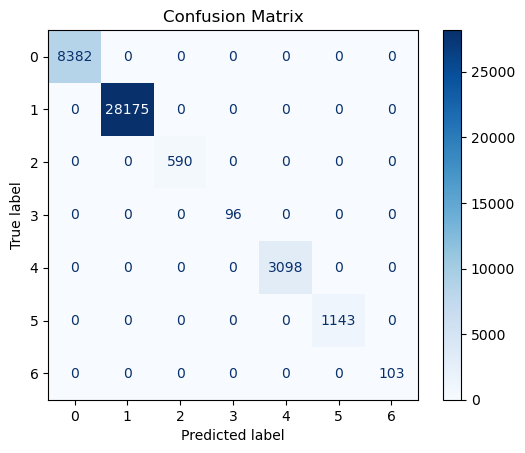

In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt

# Encode categorical variables
label_encoders = {}
for column in ['condition', 'observation', 'gender']:
    le = LabelEncoder()
    x_data[column] = le.fit_transform(x_data[column])
    label_encoders[column] = le

# Encode target variable
y_encoder = LabelEncoder()
y_data = y_encoder.fit_transform(y_data)

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

# Standardize the numerical variables
scaler = StandardScaler()
x_train_resampled[['value', 'age']] = scaler.fit_transform(x_train_resampled[['value', 'age']])
x_test[['value', 'age']] = scaler.transform(x_test[['value', 'age']])

# Train the RandomForest model with the specified parameters
best_clf = RandomForestClassifier(
    max_depth=20,
    max_features='auto',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=100,
    random_state=42
)
best_clf.fit(x_train_resampled, y_train_resampled)

# Get predicted probabilities
y_pred_prob = best_clf.predict_proba(x_test)

# Find the optimal threshold for each class
optimal_thresholds = []
for i in range(y_pred_prob.shape[1]):
    fpr, tpr, thresholds = roc_curve(y_test == i, y_pred_prob[:, i])
    optimal_idx = (tpr - fpr).argmax()
    optimal_threshold = thresholds[optimal_idx]
    optimal_thresholds.append(optimal_threshold)

# Apply optimal thresholds to make final predictions
y_pred_final = np.zeros_like(y_pred_prob)
for i in range(y_pred_prob.shape[1]):
    y_pred_final[:, i] = (y_pred_prob[:, i] >= optimal_thresholds[i]).astype(int)

y_pred_final = y_pred_final.argmax(axis=1)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_final))
print("Classification Report:\n", classification_report(y_test, y_pred_final, target_names=y_encoder.classes_.astype(str)))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt

# Encode categorical variables
label_encoders = {}
for column in ['condition', 'observation', 'gender']:
    le = LabelEncoder()
    x_data[column] = le.fit_transform(x_data[column])
    label_encoders[column] = le

# Encode target variable
y_encoder = LabelEncoder()
y_data = y_encoder.fit_transform(y_data)

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

# Standardize the numerical variables
scaler = StandardScaler()
x_train_resampled[['value', 'age']] = scaler.fit_transform(x_train_resampled[['value', 'age']])
x_test[['value', 'age']] = scaler.transform(x_test[['value', 'age']])

# Simplify the RandomForest model
clf = RandomForestClassifier(
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=50,
    random_state=42
)

# Cross-validation to validate model performance
cv_scores = cross_val_score(clf, x_train_resampled, y_train_resampled, cv=5)
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Average Cross-Validation Accuracy: {np.mean(cv_scores)}')

# Train the model
clf.fit(x_train_resampled, y_train_resampled)

# Get predicted probabilities
y_pred_prob = clf.predict_proba(x_test)

# Find the optimal threshold for each class
optimal_thresholds = []
for i in range(y_pred_prob.shape[1]):
    fpr, tpr, thresholds = roc_curve(y_test == i, y_pred_prob[:, i])
    optimal_idx = (tpr - fpr).argmax()
    optimal_threshold = thresholds[optimal_idx]
    optimal_thresholds.append(optimal_threshold)

# Apply optimal thresholds to make final predictions
y_pred_final = np.zeros_like(y_pred_prob)
for i in range(y_pred_prob.shape[1]):
    y_pred_final[:, i] = (y_pred_prob[:, i] >= optimal_thresholds[i]).astype(int)

y_pred_final = y_pred_final.argmax(axis=1)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_final))
print("Classification Report:\n", classification_report(y_test, y_pred_final, target_names=y_encoder.classes_.astype(str)))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

C:\Users\tpgo2\AppData\Local\Temp\ipykernel_2836\1983210350.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_data[column] = le.fit_transform(x_data[column])
C:\Users\tpgo2\AppData\Local\Temp\ipykernel_2836\1983210350.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_data[column] = le.fit_transform(x_data[column])
C:\Users\tpgo2\AppData\Local\Temp\ipykernel_2836\1983210350.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

ValueError: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values